Podaci nisu podijeljeni na train/valid/test

In [2]:
import re
import spacy
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
nlp = spacy.load(
    "en_core_web_lg"
)
df = pd.read_csv("train_all_tasks.csv")

Svaki redak uzorka sadržava:

In [ ]:
print(df.columns)

Broj redaka:

In [ ]:
print(df.shape[0])

Radimo s nebalansiranim skupom podataka

Broj redaka iz klase seksistički:

In [ ]:
print(len(df[df['label_sexist'] == 'sexist']))

Broj redaka iz klase neseksistički:

In [ ]:
print(len(df[df['label_sexist'] == 'not sexist']))

Nema Nan podataka:

In [ ]:
print(df.isnull().values.any())

In [ ]:
najvise = 0
seksisti = []
neseksisti = []
prosrijeci = [0, 0]
djelitelj = [0, 0]
for i in df.itertuples():
    doc = nlp(i.text.lower())
    najvise = max(najvise, len(doc))
    br_rijeci = len(doc)
    tret = [token.lemma_
         for token in doc
         if not token.is_stop and not token.is_punct and token.is_alpha]
    if i.label_sexist == 'sexist':
        prosrijeci[0] += br_rijeci
        djelitelj[0] += 1
        for j in tret:
            seksisti.append(j)
    else:
        prosrijeci[1] += br_rijeci
        djelitelj[1] += 1
        for j in tret:
            neseksisti.append(j)

Najčešće riječi za klasu seksisti:

In [ ]:
word_freq = Counter(seksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

Najčešće riječi za klasu ne seksisti:

In [ ]:
word_freq = Counter(neseksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

Broj prosječnih riječi: (tokena)
[seksisti, neseksisti]

In [ ]:
print(najvise)
prosrijeci[0] /= djelitelj[0]
prosrijeci[1] /= djelitelj[1]
print(prosrijeci)

Razdvojimo na train/valid/test:

In [3]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

lista_tekst = df["text"]
lista_label = df["label_sexist"]

for train_index, test_index in sss.split(lista_tekst, lista_label):
    X_train, X_test = lista_tekst[train_index], lista_tekst[test_index]
    y_train, y_test = lista_label[train_index], lista_label[test_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_test = {"text": X_test, "label": y_test}
    df_test = pd.DataFrame(d_test)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)

lista_tekst = np.array(df_train["text"])
lista_label = np.array(df_train["label"])

for train_index, valid_index in sss.split(lista_tekst, lista_label):
    X_train, X_valid = lista_tekst[train_index], lista_tekst[valid_index]
    y_train, y_valid = lista_label[train_index], lista_label[valid_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_valid = {"text": X_valid, "label": y_valid}
    df_valid = pd.DataFrame(d_valid)

print(len(df_test), len(df_valid), len(df_train))


2800 1400 9800


Pogledajmo [URL], [USER], emoji:

Za [URL]:

In [ ]:
urlovi = [0, 0]
sexist_c = len(df_train[df_train['label'] == 'sexist'])
nsexist_c = len(df_train[df_train['label'] == 'not sexist'])
for i in df_train.itertuples():
    kolko = i.text.count("[URL]")
    if i.label == 'sexist':
        urlovi[0] += kolko
    else:
        urlovi[1] += kolko
print(urlovi)
print(urlovi[0] / sexist_c, urlovi[0] / nsexist_c)

Za [USER]:

In [ ]:
useri = [0, 0]
for i in df_train.itertuples():
    kolko = i.text.count("[USER]")
    if i.label == 'sexist':
        useri[0] += kolko
    else:
        useri[1] += kolko
print(useri)
print(useri[0] / sexist_c, useri[1] / nsexist_c)

Za emoji:

In [ ]:
import re
a_list = ['🤔 🙈 me así, bla es se 😌 ds 💕👭👙']
re.findall(r'[^\w\s,]', a_list[0])

In [ ]:
emojiji = [0, 0]
for i in df_train.itertuples():
    doc = nlp(i.text)
    kolko = len(re.findall(r'[^\w\s,]', str(doc)[0]))
    if i.label == 'sexist':
        emojiji[0] += kolko
    else:
        emojiji[1] += kolko
print(emojiji)
print(emojiji[0] / sexist_c, emojiji[1] / nsexist_c)

SVM + WORD2VEC

In [4]:
from gensim.models import KeyedVectors
from gensim import models
from gensim.utils import simple_preprocess

word2vec_path = '.\word2vec_pretrained\GoogleNews-vectors-negative300.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)



In [4]:
model.most_similar(positive=["man"])


[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489763021469116)]

In [5]:
def W2Vvectorize(train):
    corpus_text = '\n'.join(train)
    sentences = corpus_text.split('\n')
    sentences = [line.lower().split(' ') for line in sentences]

    def clean(s):
        return [w.strip(',."!?:;()\'') for w in s]

    sentences = [clean(s) for s in sentences if len(s) > 0]
    vector=[]
    for sent in sentences:
        sent_vec=np.zeros(300)
        count =0
        for word in sent: 
            if word in model:
                vec = model[word]
                sent_vec += vec 
                count += 1
        if count != 0:
            sent_vec /= count #normalize
        vector.append(sent_vec)
    return vector

W2v prije optimizacije hiperparametara:

In [6]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
clf = SVC()

label_train = np.array(df_train["label"])
label_train = le.fit_transform(label_train)

text_train = W2Vvectorize(df_train["text"])

clf = make_pipeline(StandardScaler(),SVC(gamma='auto'))
clf = clf.fit(text_train, label_train)

In [7]:
print("Training:"+str(clf.score(text_train, label_train)))

label_test = np.array(df_test["label"])
label_test = le.fit_transform(label_test)
text_test = W2Vvectorize(df_test["text"])

print("Test:"+str(clf.score(text_test,label_test)))

Training:0.8760204081632653
Test:0.8039285714285714


In [8]:
def evaluate(model, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = W2Vvectorize(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.81      0.97      0.88      2120
      sexist       0.75      0.29      0.42       680

    accuracy                           0.80      2800
   macro avg       0.78      0.63      0.65      2800
weighted avg       0.80      0.80      0.77      2800

Precision:   0.80
   Recall:   0.80
       F1:   0.80


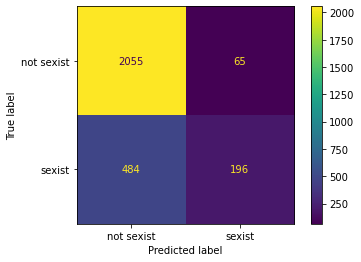

In [9]:
evaluate(clf, df_test.text, label_test)

W2v poslije optimizacije hiperparametara:

Tražimo na train i provjeravamo nad valid

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
my_test_fold = []


for i in range(len(df_train)):
    my_test_fold.append(-1)

for i in range(len(df_valid)):
    my_test_fold.append(0)

label_train = np.array(df_train["label"])
label_train = le.fit_transform(label_train)
text_train = W2Vvectorize(df_train["text"])
label_valid = np.array(df_valid["label"])
label_valid = le.fit_transform(label_valid)
text_valid = W2Vvectorize(df_valid["text"])

print(len(text_train), len(text_valid))
print(len(label_train), len(label_valid))

merged_ts = np.concatenate((text_train, text_valid),axis=0)
merged_labels = np.concatenate((label_train,  label_valid),axis=0)

print(len(merged_ts), len(merged_labels))

9800 1400
9800 1400
11200 11200


In [11]:
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
# defining parameter range
param_grid = [{'svm__C': [0.1, 1, 10],
	      'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
	      'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]
ps = PredefinedSplit(test_fold=my_test_fold)
pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("svm", SVC(class_weight='balanced'))])   
grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 3, cv=ps)

In [12]:
grid.fit(merged_ts, merged_labels)

Fitting 1 folds for each of 60 candidates, totalling 60 fits
[CV 1/1] END svm__C=0.1, svm__gamma=1, svm__kernel=linear;, score=0.689 total time=  27.9s
[CV 1/1] END svm__C=0.1, svm__gamma=1, svm__kernel=poly;, score=0.739 total time=  49.9s
[CV 1/1] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=0.757 total time=  22.5s
[CV 1/1] END svm__C=0.1, svm__gamma=1, svm__kernel=sigmoid;, score=0.543 total time=  11.4s
[CV 1/1] END svm__C=0.1, svm__gamma=0.1, svm__kernel=linear;, score=0.689 total time=  25.1s
[CV 1/1] END svm__C=0.1, svm__gamma=0.1, svm__kernel=poly;, score=0.739 total time=  48.1s
[CV 1/1] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=0.757 total time=  22.5s
[CV 1/1] END svm__C=0.1, svm__gamma=0.1, svm__kernel=sigmoid;, score=0.539 total time=  14.2s
[CV 1/1] END svm__C=0.1, svm__gamma=0.01, svm__kernel=linear;, score=0.689 total time=  25.1s
[CV 1/1] END svm__C=0.1, svm__gamma=0.01, svm__kernel=poly;, score=0.749 total time=  19.5s
[CV 1/1] END svm__C=0.1, 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(class_weight='balanced'))]),
             param_grid=[{'svm__C': [0.1, 1, 10],
                          'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             verbose=3)

In [14]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

print(grid.best_score_)

{'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=10, class_weight='balanced', gamma=0.01))])
0.7878571428571428


In [15]:
label_train = np.array(df_train["label"])
label_train = le.fit_transform(label_train)

text_train = W2Vvectorize(df_train["text"])

label_test = np.array(df_test["label"])
label_test = le.fit_transform(label_test)

clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', C=10, gamma=0.01))
clf.fit(text_train, label_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, class_weight='balanced', gamma=0.01))])

              precision    recall  f1-score   support

  not sexist       0.81      0.96      0.88      2120
      sexist       0.69      0.31      0.43       680

    accuracy                           0.80      2800
   macro avg       0.75      0.63      0.65      2800
weighted avg       0.78      0.80      0.77      2800

Precision:   0.80
   Recall:   0.80
       F1:   0.80


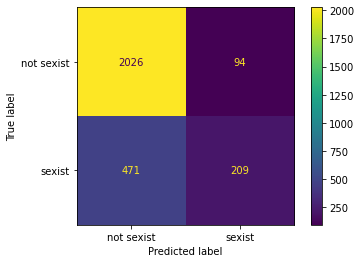

In [16]:
evaluate(clf, df_test.text, label_test)

In [17]:
import pickle
word2vec_clf = pickle.dumps(clf)

SVM +TF_IDF

TF_IDF prije optimizacije parametara:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

corpus = df_train["text"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
le = LabelEncoder()
lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

clf = SVC(C=0.1, gamma = 1, kernel = 'linear')
clf.fit(X, lista_label)

SVC(C=0.1, gamma=1, kernel='linear')

In [5]:
print("Training:"+str(clf.score(X, lista_label)))

label_test = np.array(df_test["label"])
label_test = le.transform(label_test)
text_test = vectorizer.transform(df_test["text"])

print("Test:"+str(clf.score(text_test,label_test)))

Training:0.9590816326530612
Test:0.8135714285714286


In [28]:
def evaluate(model, tf_idf, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = tf_idf.transform(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.81      0.99      0.89      2120
      sexist       0.88      0.27      0.41       680

    accuracy                           0.81      2800
   macro avg       0.84      0.63      0.65      2800
weighted avg       0.83      0.81      0.77      2800

Precision:   0.81
   Recall:   0.81
       F1:   0.81


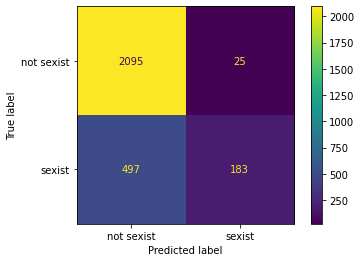

In [7]:
evaluate(clf, vectorizer, df_test.text, label_test)

TF_IDF nakon optimizacije hiperparametara:

Opet treniramo na train i provjeravamo na valid

In [4]:
my_test_fold = []


for i in range(len(df_train)):
    my_test_fold.append(-1)

for i in range(len(df_valid)):
    my_test_fold.append(0)

label_train = np.array(df_train["label"])
label_train = le.fit_transform(label_train)
text_train = vectorizer.transform(df_train["text"])
text_train = text_train.toarray()

label_valid = np.array(df_valid["label"])
label_valid = le.fit_transform(label_valid)
text_valid = vectorizer.transform(df_valid["text"])
text_valid = text_valid.toarray()

merged_ts = np.concatenate((text_train, text_valid),axis=0)
merged_labels = np.concatenate((label_train, label_valid),axis=0)


In [5]:
mergano = np.concatenate((df_train.text, df_valid.text))
merganoL = np.concatenate((df_train.label, df_valid.label))


In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
#sc.fit_transform(mergano_vect)
set1, set2, set3, set4, set5 = np.array_split(mergano, 5)
set1B, set2B, set3B, set4B, set5B = np.array_split(mergano, 5)
set1L, set2L, set3L, set4L, set5L = np.array_split(merged_labels, 5)


In [7]:
treniraj = [np.concatenate((set1, set2, set3, set4), axis=0),
            np.concatenate((set1, set2, set3, set5), axis=0),
            np.concatenate((set1, set2, set4, set5), axis=0),   
            np.concatenate((set1, set3, set4, set5), axis=0),
            np.concatenate((set2, set3, set4, set5), axis=0)]

trenirajL = [np.concatenate((set1L, set2L, set3L, set4L), axis=0),
            np.concatenate((set1L, set2L, set3L, set5L), axis=0),
            np.concatenate((set1L, set2L, set4L, set5L), axis=0),   
            np.concatenate((set1L, set3L, set4L, set5L), axis=0),
            np.concatenate((set2L, set3L, set4L, set5L), axis=0)]

for i in range (len(treniraj)):
    treniraj[i] = vectorizer.transform(treniraj[i])
    treniraj[i] = sc.fit_transform(treniraj[i])

testiraj = [set5B, set4B, set3B, set2B, set1B]

testirajL = [set5L, set4L, set3L, set2L, set1L]

for i in range (len(testiraj)):
    testiraj[i] = vectorizer.transform(testiraj[i])
    testiraj[i] = sc.fit_transform(testiraj[i])

In [8]:
param_grid = {'C': [0.1, 1, 10],
	      	'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
	      	'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [9]:
rez = np.zeros((len(param_grid['C']),len(param_grid['gamma']),len(param_grid['kernel']))) 
for m in range (len(treniraj)):  
    for i in range (len(param_grid['C'])):
        for j in range (len(param_grid['gamma'])):
            for k in range (len(param_grid['kernel'])):
                clf = SVC(C = param_grid['C'][i], gamma = param_grid['gamma'][j], kernel = param_grid['kernel'][k])
                print(clf)
                clf.fit(treniraj[m], trenirajL[m])
                print("clf.score")
                score = clf.score(testiraj[m],testirajL[m])
                print("Score:"+str(score)) 
                rez[i][j][k] += score

SVC(C=0.1, gamma=1, kernel='linear')
clf.score
Score:0.7616071428571428
SVC(C=0.1, gamma=1, kernel='poly')
clf.score
Score:0.7571428571428571
SVC(C=0.1, gamma=1)
clf.score
Score:0.7571428571428571
SVC(C=0.1, gamma=1, kernel='sigmoid')
clf.score
Score:0.6558035714285714
SVC(C=0.1, gamma=0.1, kernel='linear')
clf.score
Score:0.7616071428571428
SVC(C=0.1, gamma=0.1, kernel='poly')
clf.score
Score:0.7571428571428571
SVC(C=0.1, gamma=0.1)
clf.score
Score:0.7571428571428571
SVC(C=0.1, gamma=0.1, kernel='sigmoid')
clf.score
Score:0.7071428571428572
SVC(C=0.1, gamma=0.01, kernel='linear')
clf.score
Score:0.7616071428571428
SVC(C=0.1, gamma=0.01, kernel='poly')
clf.score
Score:0.7571428571428571
SVC(C=0.1, gamma=0.01)
clf.score
Score:0.7571428571428571
SVC(C=0.1, gamma=0.01, kernel='sigmoid')
clf.score
Score:0.8236607142857143
SVC(C=0.1, gamma=0.001, kernel='linear')
clf.score
Score:0.7616071428571428
SVC(C=0.1, gamma=0.001, kernel='poly')
clf.score
Score:0.7575892857142857
SVC(C=0.1, gamma=0.0

In [30]:
max = 0
max_i = 0
max_j = 0
max_k = 0
for i in range (len(param_grid['C'])):
        for j in range (len(param_grid['gamma'])):
            for k in range (len(param_grid['kernel'])):
                if rez[i][j][k] >= max: 
                    max = rez[i][j][k]
                    max_i = i;
                    max_j = j;
                    max_k = k;
                

In [31]:
print(max/5, "C: {}, gamma: {}, kernel: {}".format(param_grid['C'][max_i], param_grid['gamma'][max_j], param_grid['kernel'][max_k]))

0.8219642857142858 C: 0.1, gamma: 0.01, kernel: sigmoid


In [32]:
corpus = df_train["text"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
le = LabelEncoder()
lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

clf = make_pipeline(StandardScaler(with_mean = False), SVC(C=0.1, gamma = 0.01, kernel = 'sigmoid'))
clf.fit(X, lista_label)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=0.1, gamma=0.01, kernel='sigmoid'))])

In [33]:
print("Training:"+str(clf.score(X, lista_label)))

label_test = np.array(df_test["label"])
label_test = le.transform(label_test)
text_test = vectorizer.transform(df_test["text"])

print("Test:"+str(clf.score(text_test,label_test)))

Training:0.7910204081632654
Test:0.8214285714285714


              precision    recall  f1-score   support

  not sexist       0.82      0.98      0.89      2120
      sexist       0.86      0.31      0.46       680

    accuracy                           0.82      2800
   macro avg       0.84      0.65      0.68      2800
weighted avg       0.83      0.82      0.79      2800

Precision:   0.82
   Recall:   0.82
       F1:   0.82


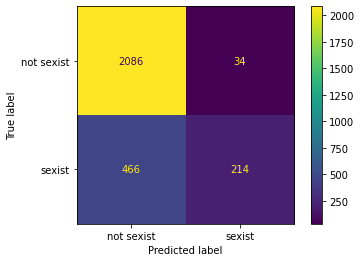

In [34]:
evaluate(clf, vectorizer, df_test.text, label_test)

In [35]:
import pickle
tfidf_clf = pickle.dumps(clf)

Ucitavanje spremljenih modela i testiranje na proizvoljnom tekstu:

In [21]:
load_w2v_clf = pickle.loads(word2vec_clf)
tekst = "woman is nice"
tekst_v = W2Vvectorize(tekst)
if round(np.mean(load_w2v_clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

not sexist


In [39]:
load_tfidf_clf = pickle.loads(tfidf_clf)
tekst = "woman is bitch"
tekst_v = vectorizer.transform([tekst])
if round(np.mean(load_tfidf_clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

sexist
